In [6]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib.parse
import time
import numpy as np
import pandas as pd
import logging
import sqlite3
from datetime import datetime

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='scraping.log'
)

# ヘッダー設定
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# SUUMOを船橋市のワンルームに絞る
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=12&sc=12204&cb=0.0&ct=9999999&et=9999999&md=01&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2='

def get_total_pages(soup):
    """
    検索結果の総ページ数を取得する関数
    
    Args:
        soup (BeautifulSoup): BeautifulSoupオブジェクト
    
    Returns:
        int: 総ページ数。取得できない場合は1を返す
    """
    try:
        pagination = soup.find(class_='pagination pagination_set-nav')
        if pagination:
            pages = pagination.find_all('a')
            if pages:
                # ページネーションの最後から2番目の要素が最終ページ
                # （最後の要素は「次へ」ボタン）
                return int(pages[-2].text)
        return 1
    except Exception as e:
        logging.error(f"総ページ数の取得に失敗: {e}")
        return 1

class RateLimiter:
    def __init__(self, requests_per_second=1):
        self.requests_per_second = requests_per_second
        self.last_request_time = 0

    def wait(self):
        current_time = time.time()
        elapsed_time = current_time - self.last_request_time
        if elapsed_time < (1 / self.requests_per_second):
            time.sleep((1 / self.requests_per_second) - elapsed_time)
        self.last_request_time = time.time()

# カウンター用クラス
class ScrapingCounter:
    def __init__(self):
        self.total_properties = 0
        self.total_buildings = 0
        self.properties_per_page = []
    
    def add_page_stats(self, buildings, properties):
        self.total_buildings += buildings
        self.total_properties += properties
        self.properties_per_page.append(properties)
    
    def get_stats(self):
        return {
            'total_properties': self.total_properties,
            'total_buildings': self.total_buildings,
            'avg_properties_per_page': np.mean(self.properties_per_page) if self.properties_per_page else 0
        }

# データベース初期化関数
def init_database():
    conn = sqlite3.connect('suumo_properties.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        category TEXT,
        building_name TEXT,
        address TEXT,
        nearest_station1 TEXT,
        nearest_station2 TEXT,
        nearest_station3 TEXT,
        building_age TEXT,
        total_floors TEXT,
        room_floor TEXT,
        rent TEXT,
        management_fee TEXT,
        deposit TEXT,
        gratuity TEXT,
        layout TEXT,
        area TEXT,
        url TEXT,
        page_number INTEGER
    )
    ''')
    
    conn.commit()
    return conn, cursor

def insert_to_database(conn, cursor, data_samples, current_page, rate_limiter, counter):
    scrape_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    insert_query = '''
    INSERT INTO properties (
        scrape_date, category, building_name, address, 
        nearest_station1, nearest_station2, nearest_station3, building_age, 
        total_floors, room_floor, rent, management_fee, 
        deposit, gratuity, layout, area, url, page_number
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    '''
    
    insert_data = []
    for sample in data_samples:
        insert_data.append((
            scrape_date, 
            sample[0], sample[1], sample[2], 
            sample[3], sample[4], sample[5], sample[6], 
            sample[7], sample[8], sample[9], sample[10], 
            sample[11], sample[12], sample[13], sample[14],
            sample[15], current_page
        ))
        
        rate_limiter.wait()
        print("---物件情報---")
        print(f"データ件数：{counter.total_properties + 1}")  # カウンターに1を加算する前の値を表示
        print(f"カテゴリ: {sample[0]}")
        print(f"建物名: {sample[1]}")
        print(f"住所: {sample[2]}")
        print(f"最寄り駅1: {sample[3]}")
        print(f"最寄り駅2: {sample[4]}")
        print(f"最寄り駅3: {sample[5]}")
        print(f"築年数: {sample[6]}")
        print(f"総階数: {sample[7]}")
        print(f"部屋階: {sample[8]}")
        print(f"家賃: {sample[9]}")
        print(f"管理費: {sample[10]}")
        print(f"敷金: {sample[11]}")
        print(f"礼金: {sample[12]}")
        print(f"間取り: {sample[13]}")
        print(f"面積: {sample[14]}")
        print(f"URL: {sample[15]}")
        print("---------------\n")
        counter.total_properties += 1  # 物件数をカウントアップ
    
    cursor.executemany(insert_query, insert_data)
    conn.commit()

@retry(tries=3, delay=10, backoff=2)
def load_page(url, rate_limiter):
    try:
        rate_limiter.wait()
        html = requests.get(url, headers=headers, timeout=10)
        html.raise_for_status()
        soup = BeautifulSoup(html.content, 'html.parser')
        return soup
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise
        
def export_to_csv(conn):
    df = pd.read_sql_query("SELECT * FROM properties", conn)
    
    filename = f'suumo_properties_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\nCSVファイル {filename} に出力しました。")
    
    print("\n--- データ概要 ---")
    print(f"総物件数: {len(df)}")
    
    try:
        df['rent_numeric'] = df['rent'].str.replace('万円', '').astype(float)
        print(f"平均家賃: {df['rent_numeric'].mean():.2f}万円")
    except:
        print("家賃の平均計算に失敗しました。")
    
    print(f"物件カテゴリ内訳:\n{df['category'].value_counts()}")

def main():
    rate_limiter = RateLimiter(requests_per_second=1)
    counter = ScrapingCounter()
    
    conn, cursor = init_database()
    data_samples = []

    first_page_soup = load_page(url, rate_limiter)
    max_page = get_total_pages(first_page_soup)
    
    start = time.time()
    times = []

    try:
        for page in range(1, max_page+1):
            before = time.time()
            page_properties = 0  # このページの物件数
            
            page_url = f"{url}&page={page}" if page > 1 else url
            
            soup = load_page(page_url, rate_limiter)
            
            mother = soup.find_all(class_='cassetteitem')
            buildings_count = len(mother)  # この階の建物数
            
            for child in mother:
                data_home = []
                
                try:
                    data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_content-title').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_detail-col1').text)
                except:
                    data_home.append('不明')
                
                try:
                    children = child.find(class_='cassetteitem_detail-col2')
                    stations = children.find_all(class_='cassetteitem_detail-text')
                    for id, grandchild in enumerate(stations[:3]):
                        data_home.append(grandchild.text)
                    while len(data_home) < 6:
                        data_home.append('不明')
                except:
                    data_home.extend(['不明', '不明', '不明'])
                
                try:
                    children = child.find(class_='cassetteitem_detail-col3')
                    building_info = children.find_all('div')
                    data_home.extend([building_info[0].text, building_info[1].text])
                except:
                    data_home.extend(['不明', '不明'])

                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    
                    room_tds = room.find_all('td')
                    for id_, grandchild in enumerate(room_tds):
                        try:
                            if id_ == 2:
                                data_room.append(grandchild.text.strip())
                            
                            elif id_ == 3:
                                rent = grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text
                                management_fee = grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text
                                data_room.append(rent)
                                data_room.append(management_fee)
                            
                            elif id_ == 4:
                                deposit = grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text
                                gratuity = grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text
                                data_room.append(deposit)
                                data_room.append(gratuity)
                            
                            elif id_ == 5:
                                layout = grandchild.find(class_='cassetteitem_madori').text
                                area = grandchild.find(class_='cassetteitem_menseki').text
                                data_room.append(layout)
                                data_room.append(area)
                            
                            elif id_ == 8:
                                get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                                abs_url = urllib.parse.urljoin(url, get_url)
                                data_room.append(abs_url)
                        
                        except Exception as e:
                            data_room.append('不明')
                    
                    data_sample = data_home + data_room
                    data_samples.append(data_sample)
                    page_properties += 1
            
            # ページの統計を追加
            counter.add_page_stats(buildings_count, page_properties)
            
            insert_to_database(conn, cursor, data_samples, page, rate_limiter, counter)
            data_samples = []
            
            after = time.time()
            running_time = after - before
            times.append(running_time)
            
            stats = counter.get_stats()
            print(f'\n{page}ページ目の統計:')
            print(f'このページの建物数: {buildings_count}')
            print(f'このページの物件数: {page_properties}')
            print(f'累計建物数: {stats["total_buildings"]}')
            print(f'累計物件数: {stats["total_properties"]}')
            print(f'ページあたり平均物件数: {stats["avg_properties_per_page"]:.1f}')
            print(f'処理時間: {running_time:.1f}秒')
            
            complete_ratio = round(page/max_page*100, 3)
            print(f'完了：{complete_ratio}%')
            
            running_mean = np.mean(times)
            running_required_time = running_mean * (max_page - page)
            hour = int(running_required_time/3600)
            minute = int((running_required_time%3600)/60)
            second = int(running_required_time%60)
            print(f'残り時間：{hour}時間{minute}分{second}秒\n')

            logging.info(f'ページ {page} スクレイピング完了 (建物数: {buildings_count}, 物件数: {page_properties})')

    except Exception as e:
        logging.error(f"スクレイピング中にエラー発生: {e}")
        print(f"エラー: {e}")
    
    finish = time.time()
    running_all = finish - start
    
    # 最終統計
    final_stats = counter.get_stats()
    print('\n=== 最終統計 ===')
    print(f'総建物数: {final_stats["total_buildings"]}')
    print(f'総物件数: {final_stats["total_properties"]}')
    print(f'ページあたり平均物件数: {final_stats["avg_properties_per_page"]:.1f}')
    print(f'総経過時間: {running_all:.1f}秒')

    export_to_csv(conn)
    conn.close()
    logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

---物件情報---
データ件数：108
カテゴリ: 賃貸アパート
建物名: ブランノワール船橋
住所: 千葉県船橋市宮本１
最寄り駅1: 京成本線/大神宮下駅 歩7分
最寄り駅2: ＪＲ総武線/船橋駅 歩9分
最寄り駅3: 京成本線/京成船橋駅 歩8分
築年数: 築5年
総階数: 3階建
部屋階: 1階
家賃: 6.5万円
管理費: 5000円
敷金: -
礼金: -
間取り: ワンルーム
面積: 18.72m2
URL: https://suumo.jp/chintai/jnc_000095702242/?bc=100417144369
---------------

---物件情報---
データ件数：109
カテゴリ: 賃貸アパート
建物名: ブランノワール船橋
住所: 千葉県船橋市宮本１
最寄り駅1: 京成本線/大神宮下駅 歩7分
最寄り駅2: ＪＲ総武線/船橋駅 歩9分
最寄り駅3: 京成本線/京成船橋駅 歩8分
築年数: 築5年
総階数: 3階建
部屋階: 1階
家賃: 6.4万円
管理費: 7000円
敷金: -
礼金: -
間取り: ワンルーム
面積: 18.72m2
URL: https://suumo.jp/chintai/jnc_000095019299/?bc=100343214501
---------------



KeyboardInterrupt: 

In [26]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib.parse
import time
import numpy as np
import pandas as pd
import logging
import sqlite3
from datetime import datetime

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='scraping.log'
)

# ヘッダー設定
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# SUUMOを船橋市のワンルームに絞る
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ra=012&cb=0.0&ct=9999999&et=9999999&md=03&md=04&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&ek=055732150&rn=0557&srch_navi=1'

def get_total_pages(soup):
    """
    検索結果の総ページ数を取得する関数
    
    Args:
        soup (BeautifulSoup): BeautifulSoupオブジェクト
    
    Returns:
        int: 総ページ数。取得できない場合は1を返す
    """
    try:
        pagination = soup.find(class_='pagination pagination_set-nav')
        if pagination:
            pages = pagination.find_all('a')
            if pages:
                # ページネーションの最後から2番目の要素が最終ページ
                # （最後の要素は「次へ」ボタン）
                return int(pages[-2].text)
        return 1
    except Exception as e:
        logging.error(f"総ページ数の取得に失敗: {e}")
        return 1

class RateLimiter:
    def __init__(self, requests_per_second=1):
        self.requests_per_second = requests_per_second
        self.last_request_time = 0

    def wait(self):
        current_time = time.time()
        elapsed_time = current_time - self.last_request_time
        if elapsed_time < (1 / self.requests_per_second):
            time.sleep((1 / self.requests_per_second) - elapsed_time)
        self.last_request_time = time.time()

# カウンター用クラス
class ScrapingCounter:
    def __init__(self):
        self.total_properties = 0
        self.total_buildings = 0
        self.properties_per_page = []
    
    def add_page_stats(self, buildings, properties):
        self.total_buildings += buildings
        self.total_properties += properties
        self.properties_per_page.append(properties)
    
    def get_stats(self):
        return {
            'total_properties': self.total_properties,
            'total_buildings': self.total_buildings,
            'avg_properties_per_page': np.mean(self.properties_per_page) if self.properties_per_page else 0
        }

# データベース初期化関数
def init_database():
    conn = sqlite3.connect('suumo_properties.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        category TEXT,
        building_name TEXT,
        address TEXT,
        nearest_station1 TEXT,
        nearest_station2 TEXT,
        nearest_station3 TEXT,
        building_age TEXT,
        total_floors TEXT,
        room_floor TEXT,
        rent TEXT,
        management_fee TEXT,
        deposit TEXT,
        gratuity TEXT,
        layout TEXT,
        area TEXT,
        url TEXT,
        page_number INTEGER
    )
    ''')
    
    conn.commit()
    return conn, cursor

def insert_to_database(conn, cursor, data_samples, current_page, rate_limiter, counter):
    scrape_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    insert_query = '''
    INSERT INTO properties (
        scrape_date, category, building_name, address, 
        nearest_station1, nearest_station2, nearest_station3, building_age, 
        total_floors, room_floor, rent, management_fee, 
        deposit, gratuity, layout, area, url, page_number
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    '''
    
    insert_data = []
    for sample in data_samples:
        insert_data.append((
            scrape_date, 
            sample[0], sample[1], sample[2], 
            sample[3], sample[4], sample[5], sample[6], 
            sample[7], sample[8], sample[9], sample[10], 
            sample[11], sample[12], sample[13], sample[14],
            sample[15], current_page
        ))
        
        rate_limiter.wait()
        print("---物件情報---")
        print(f"データ件数：{counter.total_properties + 1}")  # カウンターに1を加算する前の値を表示
        print(f"カテゴリ: {sample[0]}")
        print(f"建物名: {sample[1]}")
        print(f"住所: {sample[2]}")
        print(f"最寄り駅1: {sample[3]}")
        print(f"最寄り駅2: {sample[4]}")
        print(f"最寄り駅3: {sample[5]}")
        print(f"築年数: {sample[6]}")
        print(f"総階数: {sample[7]}")
        print(f"部屋階: {sample[8]}")
        print(f"家賃: {sample[9]}")
        print(f"管理費: {sample[10]}")
        print(f"敷金: {sample[11]}")
        print(f"礼金: {sample[12]}")
        print(f"間取り: {sample[13]}")
        print(f"面積: {sample[14]}")
        print(f"URL: {sample[15]}")
        print("---------------\n")
        counter.total_properties += 1  # 物件数をカウントアップ
    
    cursor.executemany(insert_query, insert_data)
    conn.commit()

@retry(tries=3, delay=10, backoff=2)
def load_page(url, rate_limiter):
    try:
        rate_limiter.wait()
        html = requests.get(url, headers=headers, timeout=10)
        html.raise_for_status()
        soup = BeautifulSoup(html.content, 'html.parser')
        return soup
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise
        
def export_to_csv(conn):
    df = pd.read_sql_query("SELECT * FROM properties", conn)
    
    filename = f'suumo_properties_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\nCSVファイル {filename} に出力しました。")
    
    print("\n--- データ概要 ---")
    print(f"総物件数: {len(df)}")
    
    try:
        df['rent_numeric'] = df['rent'].str.replace('万円', '').astype(float)
        print(f"平均家賃: {df['rent_numeric'].mean():.2f}万円")
    except:
        print("家賃の平均計算に失敗しました。")
    
    print(f"物件カテゴリ内訳:\n{df['category'].value_counts()}")

def main():
    rate_limiter = RateLimiter(requests_per_second=1)
    counter = ScrapingCounter()
    
    conn, cursor = init_database()
    data_samples = []

    first_page_soup = load_page(url, rate_limiter)
    max_page = get_total_pages(first_page_soup)
    
    start = time.time()
    times = []

    try:
        for page in range(1, max_page+1):
            before = time.time()
            page_properties = 0  # このページの物件数
            
            page_url = f"{url}&page={page}" if page > 1 else url
            
            soup = load_page(page_url, rate_limiter)
            
            mother = soup.find_all(class_='cassetteitem')
            buildings_count = len(mother)  # この階の建物数
            
            for child in mother:
                data_home = []
                
                try:
                    data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_content-title').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_detail-col1').text)
                except:
                    data_home.append('不明')
                
                try:
                    children = child.find(class_='cassetteitem_detail-col2')
                    stations = children.find_all(class_='cassetteitem_detail-text')
                    for id, grandchild in enumerate(stations[:3]):
                        data_home.append(grandchild.text)
                    while len(data_home) < 6:
                        data_home.append('不明')
                except:
                    data_home.extend(['不明', '不明', '不明'])
                
                try:
                    children = child.find(class_='cassetteitem_detail-col3')
                    building_info = children.find_all('div')
                    data_home.extend([building_info[0].text, building_info[1].text])
                except:
                    data_home.extend(['不明', '不明'])

                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    
                    room_tds = room.find_all('td')
                    for id_, grandchild in enumerate(room_tds):
                        try:
                            if id_ == 2:
                                data_room.append(grandchild.text.strip())
                            
                            elif id_ == 3:
                                rent = grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text
                                management_fee = grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text
                                data_room.append(rent)
                                data_room.append(management_fee)
                            
                            elif id_ == 4:
                                deposit = grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text
                                gratuity = grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text
                                data_room.append(deposit)
                                data_room.append(gratuity)
                            
                            elif id_ == 5:
                                layout = grandchild.find(class_='cassetteitem_madori').text
                                area = grandchild.find(class_='cassetteitem_menseki').text
                                data_room.append(layout)
                                data_room.append(area)
                            
                            elif id_ == 8:
                                get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                                abs_url = urllib.parse.urljoin(url, get_url)
                                data_room.append(abs_url)
                        
                        except Exception as e:
                            data_room.append('不明')
                    
                    data_sample = data_home + data_room
                    data_samples.append(data_sample)
                    page_properties += 1
            
            # ページの統計を追加
            counter.add_page_stats(buildings_count, page_properties)
            
            insert_to_database(conn, cursor, data_samples, page, rate_limiter, counter)
            data_samples = []
            
            after = time.time()
            running_time = after - before
            times.append(running_time)
            
            stats = counter.get_stats()
            print(f'\n{page}ページ目の統計:')
            print(f'このページの建物数: {buildings_count}')
            print(f'このページの物件数: {page_properties}')
            print(f'累計建物数: {stats["total_buildings"]}')
            print(f'累計物件数: {stats["total_properties"]}')
            print(f'ページあたり平均物件数: {stats["avg_properties_per_page"]:.1f}')
            print(f'処理時間: {running_time:.1f}秒')
            
            complete_ratio = round(page/max_page*100, 3)
            print(f'完了：{complete_ratio}%')
            
            running_mean = np.mean(times)
            running_required_time = running_mean * (max_page - page)
            hour = int(running_required_time/3600)
            minute = int((running_required_time%3600)/60)
            second = int(running_required_time%60)
            print(f'残り時間：{hour}時間{minute}分{second}秒\n')

            logging.info(f'ページ {page} スクレイピング完了 (建物数: {buildings_count}, 物件数: {page_properties})')

    except Exception as e:
        logging.error(f"スクレイピング中にエラー発生: {e}")
        print(f"エラー: {e}")
    
    finish = time.time()
    running_all = finish - start
    
    # 最終統計
    final_stats = counter.get_stats()
    print('\n=== 最終統計 ===')
    print(f'総建物数: {final_stats["total_buildings"]}')
    print(f'総物件数: {final_stats["total_properties"]}')
    print(f'ページあたり平均物件数: {final_stats["avg_properties_per_page"]:.1f}')
    print(f'総経過時間: {running_all:.1f}秒')

    export_to_csv(conn)
    conn.close()
    logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

---物件情報---
データ件数：6
カテゴリ: 賃貸アパート
建物名: ＪＲ成田線 空港第２ビル駅 2階建 築32年
住所: 千葉県成田市新田
最寄り駅1: ＪＲ成田線/空港第２ビル駅 歩59分
最寄り駅2: 京成本線/東成田駅 車12分(4.9km)
最寄り駅3: ＪＲ成田線/成田駅 車24分(11.1km)
築年数: 築32年
総階数: 2階建
部屋階: 1階
家賃: 2.7万円
管理費: 3000円
敷金: -
礼金: 2.7万円
間取り: 1DK
面積: 26.5m2
URL: https://suumo.jp/chintai/jnc_000095645383/?bc=100416691532
---------------

---物件情報---
データ件数：7
カテゴリ: 賃貸アパート
建物名: ＪＲ成田線 成田空港駅 2階建 築21年
住所: 千葉県成田市三里塚御料
最寄り駅1: ＪＲ成田線/成田空港駅 歩93分
最寄り駅2: 芝山鉄道/芝山千代田駅 歩66分
最寄り駅3: 京成本線/東成田駅 歩86分
築年数: 築21年
総階数: 2階建
部屋階: 1階
家賃: 5.2万円
管理費: 4500円
敷金: -
礼金: 2.6万円
間取り: 1LDK
面積: 41.5m2
URL: https://suumo.jp/chintai/jnc_000095687513/?bc=100234579938
---------------

---物件情報---
データ件数：8
カテゴリ: 賃貸アパート
建物名: サンプレイス
住所: 千葉県成田市大清水
最寄り駅1: ＪＲ成田線/成田空港駅 歩79分
最寄り駅2: 京成本線/東成田駅 歩73分
最寄り駅3: ＪＲ成田線/空港第２ビル駅 歩71分
築年数: 築16年
総階数: 2階建
部屋階: 1階
家賃: 5.9万円
管理費: 4500円
敷金: -
礼金: 2.95万円
間取り: 1LDK
面積: 45m2
URL: https://suumo.jp/chintai/jnc_000095682314/?bc=100417015183
---------------

---物件情報---
データ件数：9
カテゴリ: 賃貸アパート
建物名: セレーナ　I
住所: 千葉県成田市本三里塚
最寄り駅1: ＪＲ成田線/

In [43]:
import os
import sqlite3
from datetime import datetime

def clear_database_and_csv():
    # SQLiteデータベースをクリア
    try:
        conn = sqlite3.connect('suumo_properties.db')
        cursor = conn.cursor()
        
        # テーブルの中身を削除
        cursor.execute('DELETE FROM properties')
        
        # AUTO_INCREMENTをリセット
        cursor.execute('DELETE FROM sqlite_sequence WHERE name="properties"')
        
        conn.commit()
        print("データベースの中身を正常にクリアしました")
        
    except Exception as e:
        print(f"データベースのクリア中にエラーが発生しました: {e}")
    
    finally:
        if conn:
            conn.close()

    # CSVファイルを削除
    try:
        # suumo_properties_で始まるすべてのCSVファイルを検索
        csv_files = [f for f in os.listdir('.') if f.startswith('suumo_properties_') and f.endswith('.csv')]
        
        # 各ファイルを削除
        for file in csv_files:
            os.remove(file)
            print(f"{file} を削除しました")
        
    except Exception as e:
        print(f"CSVファイルの削除中にエラーが発生しました: {e}")

if __name__ == "__main__":
    clear_database_and_csv()

データベースの中身を正常にクリアしました


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def clean_numeric_data(value):
    """数値データをクリーニングする関数"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        # 家賃データのクリーニング（例：'5.2万円' → 5.2）
        if '万円' in value:
            return float(value.replace('万円', ''))
        # 面積データのクリーニング（例：'45m2' → 45.0）
        if 'm2' in value:
            return float(value.replace('m2', ''))
    return value

def create_rent_area_scatter(csv_path, output_path=None):
    """
    家賃と面積の散布図を作成する関数
    """
    # データの読み込み
    df = pd.read_csv(csv_path)
    
    # 家賃と面積のデータをクリーニング
    df['rent_cleaned'] = df['rent'].apply(clean_numeric_data)
    df['area_cleaned'] = df['area'].apply(clean_numeric_data)
    
    # 欠損値を除外
    df_clean = df.dropna(subset=['rent_cleaned', 'area_cleaned'])
    
    # プロットの設定
    plt.figure(figsize=(10, 6))
    
    # 散布図の作成（x軸とy軸を入れ替え）
    sns.scatterplot(data=df_clean, 
                   x='area_cleaned', 
                   y='rent_cleaned',
                   alpha=0.6)
    
    # グラフの設定
    plt.title('面積と家賃の関係', fontsize=14, pad=15)
    plt.xlabel('面積 (m²)', fontsize=12)
    plt.ylabel('家賃 (万円)', fontsize=12)
    
    # グリッド線の追加
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 相関係数の計算と表示
    correlation = df_clean['rent_cleaned'].corr(df_clean['area_cleaned'])
    plt.text(0.05, 0.95, f'相関係数: {correlation:.2f}', 
             transform=plt.gca().transAxes, 
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # グラフの保存または表示
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"グラフを {output_path} に保存しました。")
    else:
        plt.show()
    
    plt.close()
    
    # 基本統計量の表示
    print("\n基本統計量:")
    stats = pd.DataFrame({
        '家賃 (万円)': df_clean['rent_cleaned'].describe(),
        '面積 (m²)': df_clean['area_cleaned'].describe()
    })
    print(stats)

# CSVデータを使用して散布図を作成
create_rent_area_scatter("suumo_properties_20250115_110631.csv", "rent_area_scatter.png")

/var/folders/c_/0m_fgjzj07j3vkyffsx_4lg00000gn/T/ipykernel_39246/1971835256.py:59: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/c_/0m_fgjzj07j3vkyffsx_4lg00000gn/T/ipykernel_39246/1971835256.py:59: UserWarning: Glyph 36035 (\N{CJK UNIFIED IDEOGRAPH-8CC3}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/c_/0m_fgjzj07j3vkyffsx_4lg00000gn/T/ipykernel_39246/1971835256.py:59: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/c_/0m_fgjzj07j3vkyffsx_4lg00000gn/T/ipykernel_39246/1971835256.py:59: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/var/folders/c_/0m_fgjzj07j3vkyffsx_4lg00000gn/T/ipykernel_39246/1971835

グラフを rent_area_scatter.png に保存しました。

基本統計量:
        家賃 (万円)    面積 (m²)
count  5.000000   5.000000
mean   5.400000  40.052000
std    1.641646   7.769895
min    2.700000  26.500000
25%    5.200000  41.500000
50%    5.900000  41.950000
75%    6.200000  45.000000
max    7.000000  45.310000


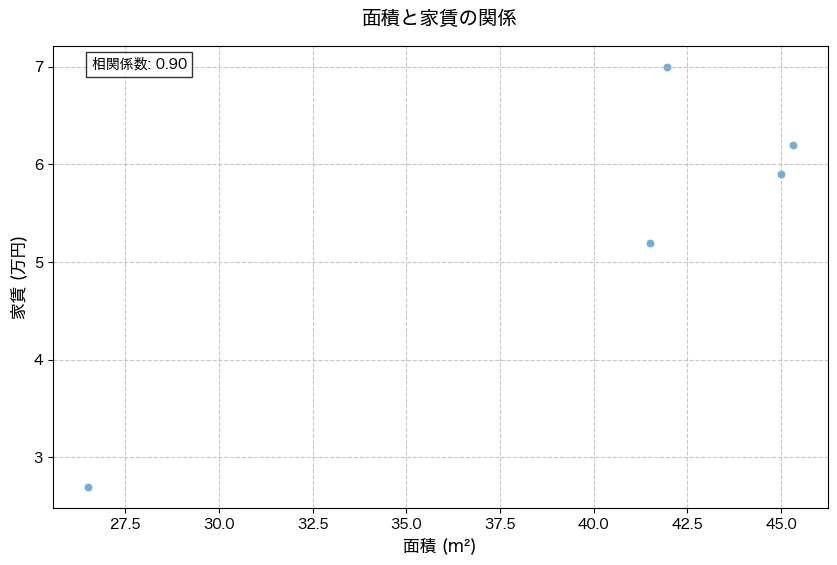


基本統計量:
        家賃 (万円)    面積 (m²)
count  5.000000   5.000000
mean   5.400000  40.052000
std    1.641646   7.769895
min    2.700000  26.500000
25%    5.200000  41.500000
50%    5.900000  41.950000
75%    6.200000  45.000000
max    7.000000  45.310000


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams

# フォントの設定
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

def clean_numeric_data(value):
    """数値データをクリーニングする関数"""
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        # 家賃データのクリーニング（例：'5.2万円' → 5.2）
        if '万円' in value:
            return float(value.replace('万円', ''))
        # 面積データのクリーニング（例：'45m2' → 45.0）
        if 'm2' in value:
            return float(value.replace('m2', ''))
    return value

def create_rent_area_scatter(csv_path):
    """
    家賃と面積の散布図を作成する関数
    """
    # データの読み込み
    df = pd.read_csv(csv_path)
    
    # 家賃と面積のデータをクリーニング
    df['rent_cleaned'] = df['rent'].apply(clean_numeric_data)
    df['area_cleaned'] = df['area'].apply(clean_numeric_data)
    
    # 欠損値を除外
    df_clean = df.dropna(subset=['rent_cleaned', 'area_cleaned'])
    
    # プロットの設定
    plt.figure(figsize=(10, 6))
    
    # 散布図の作成（x軸とy軸を入れ替え）
    sns.scatterplot(data=df_clean, 
                   x='area_cleaned', 
                   y='rent_cleaned',
                   alpha=0.6)
    
    # グラフの設定
    plt.title('面積と家賃の関係', fontsize=14, pad=15)
    plt.xlabel('面積 (m²)', fontsize=12)
    plt.ylabel('家賃 (万円)', fontsize=12)
    
    # グリッド線の追加
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 相関係数の計算と表示
    correlation = df_clean['rent_cleaned'].corr(df_clean['area_cleaned'])
    plt.text(0.05, 0.95, f'相関係数: {correlation:.2f}', 
             transform=plt.gca().transAxes, 
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8))
    
    # グラフの表示
    plt.show()
    
    # 基本統計量の表示
    print("\n基本統計量:")
    stats = pd.DataFrame({
        '家賃 (万円)': df_clean['rent_cleaned'].describe(),
        '面積 (m²)': df_clean['area_cleaned'].describe()
    })
    print(stats)

# CSVデータを使用して散布図を作成
create_rent_area_scatter("suumo_properties_20250115_110631.csv")

In [ ]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib.parse
import time
import numpy as np
import pandas as pd
import logging
import sqlite3
from datetime import datetime
import random
from fake_useragent import UserAgent
import json

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='scraping.log'
)

class SessionManager:
    def __init__(self):
        self.session = requests.Session()
        self.ua = UserAgent()
        self.update_headers()
    
    def update_headers(self):
        self.session.headers.update({
            'User-Agent': self.ua.random,
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'ja,en-US;q=0.7,en;q=0.3',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
            'Cache-Control': 'max-age=0'
        })

class RateLimiter:
    def __init__(self, base_delay=2):
        self.base_delay = base_delay
    
    def wait(self):
        delay = self.base_delay + random.uniform(0.5, 1.5)
        time.sleep(delay)

class ScrapingCounter:
    def __init__(self):
        self.total_properties = 0
        self.total_buildings = 0
        self.properties_per_page = []
        self.processed_urls = set()
    
    def add_page_stats(self, buildings, properties):
        self.total_buildings += buildings
        self.total_properties += properties
        self.properties_per_page.append(properties)
    
    def get_stats(self):
        return {
            'total_properties': self.total_properties,
            'total_buildings': self.total_buildings,
            'avg_properties_per_page': np.mean(self.properties_per_page) if self.properties_per_page else 0
        }

def init_database():
    conn = sqlite3.connect('suumo_properties.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        category TEXT,
        building_name TEXT,
        address TEXT,
        nearest_station1 TEXT,
        nearest_station2 TEXT,
        nearest_station3 TEXT,
        building_age TEXT,
        total_floors TEXT,
        room_floor TEXT,
        rent TEXT,
        management_fee TEXT,
        deposit TEXT,
        gratuity TEXT,
        layout TEXT,
        area TEXT,
        url TEXT UNIQUE,
        page_number INTEGER,
        UNIQUE(url)
    )
    ''')
    
    # インデックスの作成
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_url ON properties(url)')
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_scrape_date ON properties(scrape_date)')
    
    conn.commit()
    return conn, cursor

@retry(tries=5, delay=30, backoff=2, jitter=(1, 3))
def get_total_pages(session, base_url):
    """
    より堅牢なページ数取得関数
    """
    try:
        response = session.session.get(base_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # 複数の方法でページ数を取得
        pagination = soup.find(class_='pagination pagination_set-nav')
        if pagination:
            pages = pagination.find_all('a')
            if pages:
                try:
                    # すべてのページ番号を取得して最大値を使用
                    page_numbers = [int(p.text) for p in pages if p.text.isdigit()]
                    if page_numbers:
                        return max(page_numbers)
                except ValueError:
                    pass
        
        # 物件数から推定（SUUMOは1ページあたり最大20件）
        total_count_element = soup.find(class_='cassetteitem')
        if total_count_element:
            count_text = total_count_element.get_text()
            try:
                total_count = int(count_text)
                return (total_count + 19) // 20
            except (ValueError, AttributeError):
                pass
        
        logging.warning("ページ数の取得に失敗。デフォルト値を使用します。")
        return 50  # デフォルト値
    
    except Exception as e:
        logging.error(f"ページ数取得エラー: {e}")
        raise

def extract_room_data(room, base_url):
    """
    個別の部屋データを抽出する関数
    """
    data_room = []
    room_tds = room.find_all('td')
    
    try:
        # 階数
        data_room.append(room_tds[2].text.strip() if len(room_tds) > 2 else '不明')
        
        # 家賃と管理費
        if len(room_tds) > 3:
            rent = room_tds[3].find(class_='cassetteitem_other-emphasis ui-text--bold')
            rent = rent.text if rent else '不明'
            management_fee = room_tds[3].find(class_='cassetteitem_price cassetteitem_price--administration')
            management_fee = management_fee.text if management_fee else '不明'
        else:
            rent, management_fee = '不明', '不明'
        data_room.extend([rent, management_fee])
        
        # 敷金・礼金
        if len(room_tds) > 4:
            deposit = room_tds[4].find(class_='cassetteitem_price cassetteitem_price--deposit')
            deposit = deposit.text if deposit else '不明'
            gratuity = room_tds[4].find(class_='cassetteitem_price cassetteitem_price--gratuity')
            gratuity = gratuity.text if gratuity else '不明'
        else:
            deposit, gratuity = '不明', '不明'
        data_room.extend([deposit, gratuity])
        
        # 間取りと面積
        if len(room_tds) > 5:
            layout = room_tds[5].find(class_='cassetteitem_madori')
            layout = layout.text if layout else '不明'
            area = room_tds[5].find(class_='cassetteitem_menseki')
            area = area.text if area else '不明'
        else:
            layout, area = '不明', '不明'
        data_room.extend([layout, area])
        
        # URL
        if len(room_tds) > 8:
            url_element = room_tds[8].find(class_='js-cassette_link_href')
            if url_element and 'href' in url_element.attrs:
                url = urllib.parse.urljoin(base_url, url_element['href'])
            else:
                url = '不明'
        else:
            url = '不明'
        data_room.append(url)
        
    except Exception as e:
        logging.error(f"部屋データ抽出エラー: {e}")
        remaining_fields = 7 - len(data_room)
        data_room.extend(['不明'] * remaining_fields)
    
    return data_room

def process_building(building, base_url):
    """
    建物ごとのデータを処理する関数
    """
    data_home = []
    
    # カテゴリ
    category = building.find(class_='ui-pct ui-pct--util1')
    data_home.append(category.text if category else '不明')
    
    # 建物名
    title = building.find(class_='cassetteitem_content-title')
    data_home.append(title.text if title else '不明')
    
    # 住所
    address = building.find(class_='cassetteitem_detail-col1')
    data_home.append(address.text if address else '不明')
    
    # 最寄り駅
    stations = building.select('.cassetteitem_detail-col2 .cassetteitem_detail-text')
    for i in range(3):
        if i < len(stations):
            data_home.append(stations[i].text)
        else:
            data_home.append('不明')
    
    # 建物情報
    building_info = building.select('.cassetteitem_detail-col3 div')
    for i in range(2):
        if i < len(building_info):
            data_home.append(building_info[i].text)
        else:
            data_home.append('不明')
    
    return data_home

def check_for_captcha(soup):
    """
    CAPTCHAページかどうかを確認する関数
    """
    captcha_indicators = [
        'CAPTCHA',
        'ロボットではありません',
        '認証',
        'セキュリティチェック'
    ]
    
    page_text = soup.get_text().lower()
    return any(indicator.lower() in page_text for indicator in captcha_indicators)

@retry(tries=3, delay=10, backoff=2)
def load_page(session, url, rate_limiter):
    """
    ページを読み込む関数（改善版）
    """
    try:
        rate_limiter.wait()
        session.update_headers()  # 毎回ヘッダーを更新
        
        response = session.session.get(url, timeout=30)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        if check_for_captcha(soup):
            logging.error("CAPTCHAページを検出")
            raise Exception("CAPTCHA detected")
        
        return soup
    
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise

def save_progress(counter, current_page):
    """
    進捗状況を保存する関数
    """
    progress = {
        'last_page': current_page,
        'processed_urls': list(counter.processed_urls),
        'stats': counter.get_stats()
    }
    
    with open('scraping_progress.json', 'w') as f:
        json.dump(progress, f)

def load_progress():
    """
    保存された進捗状況を読み込む関数
    """
    try:
        with open('scraping_progress.json', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return None

def main():
    base_url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&pc=30&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sc=12204&ta=12&cb=0.0&ct=9999999&md=01&et=9999999&mb=0&mt=9999999&cn=9999999&fw2='
    
    session_manager = SessionManager()
    rate_limiter = RateLimiter(base_delay=2)
    counter = ScrapingCounter()
    
    # データベース接続
    conn, cursor = init_database()
    
    # 進捗状況の読み込み
    progress = load_progress()
    start_page = 1
    if progress:
        start_page = progress['last_page']
        counter.processed_urls = set(progress['processed_urls'])
        logging.info(f"前回の進捗から再開: ページ {start_page}")
    
    try:
        # 総ページ数の取得
        max_page = get_total_pages(session_manager, base_url)
        logging.info(f"取得した総ページ数: {max_page}")
        
        start_time = time.time()
        times = []
        
        for page in range(start_page, max_page + 1):
            before = time.time()
            
            page_url = f"{base_url}&page={page}" if page > 1 else base_url
            
            try:
                soup = load_page(session_manager, page_url, rate_limiter)
                buildings = soup.find_all(class_='cassetteitem')
                
                page_properties = 0
                
                for building in buildings:
                    try:
                        data_home = process_building(building, base_url)
                        
                        rooms = building.find(class_='cassetteitem_other')
                        for room in rooms.find_all(class_='js-cassette_link'):
                            data_room = extract_room_data(room, base_url)
                            
                            if data_room[-1] != '不明' and data_room[-1] not in counter.processed_urls:
                                data_sample = data_home + data_room
                                
                                # データベースに保存
                                try:
                                    cursor.execute('''
                                        INSERT OR IGNORE INTO properties 
                                        (scrape_date, category, building_name, address, 
                                        nearest_station1, nearest_station2, nearest_station3, 
                                        building_age, total_floors, room_floor, rent, 
                                        management_fee, deposit, gratuity, layout, area, 
                                        url, page_number)
                                         VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                                    ''', (
                                        datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                                        *data_sample,
                                        page
                                    ))
                                    conn.commit()
                                    
                                    counter.processed_urls.add(data_room[-1])
                                    page_properties += 1
                                    
                                    print(f"データ追加成功: {data_sample[1]} - {data_sample[-2]}")
                                
                                except sqlite3.IntegrityError:
                                    logging.warning(f"重複データをスキップ: {data_room[-1]}")
                                    continue
                                
                                except Exception as e:
                                    logging.error(f"データベース挿入エラー: {e}")
                                    continue
                    
                    except Exception as e:
                        logging.error(f"建物データ処理エラー: {e}")
                        continue
                
                # ページの統計を更新
                counter.add_page_stats(len(buildings), page_properties)
                
                # 進捗状況の保存
                save_progress(counter, page)
                
                # 処理時間の計算と表示
                after = time.time()
                running_time = after - before
                times.append(running_time)
                
                stats = counter.get_stats()
                print(f'\n{page}ページ目の統計:')
                print(f'このページの建物数: {len(buildings)}')
                print(f'このページの物件数: {page_properties}')
                print(f'累計建物数: {stats["total_buildings"]}')
                print(f'累計物件数: {stats["total_properties"]}')
                print(f'ページあたり平均物件数: {stats["avg_properties_per_page"]:.1f}')
                print(f'処理時間: {running_time:.1f}秒')
                
                complete_ratio = round(page/max_page*100, 3)
                print(f'完了：{complete_ratio}%')
                
                if times:
                    running_mean = np.mean(times)
                    running_required_time = running_mean * (max_page - page)
                    hour = int(running_required_time/3600)
                    minute = int((running_required_time%3600)/60)
                    second = int(running_required_time%60)
                    print(f'残り時間：{hour}時間{minute}分{second}秒\n')
                
                logging.info(f'ページ {page} スクレイピング完了 (建物数: {len(buildings)}, 物件数: {page_properties})')
            
            except Exception as e:
                logging.error(f"ページ {page} の処理中にエラー: {e}")
                continue
        
        finish = time.time()
        running_all = finish - start_time
        
        # 最終統計
        final_stats = counter.get_stats()
        print('\n=== 最終統計 ===')
        print(f'総建物数: {final_stats["total_buildings"]}')
        print(f'総物件数: {final_stats["total_properties"]}')
        print(f'ページあたり平均物件数: {final_stats["avg_properties_per_page"]:.1f}')
        print(f'総経過時間: {running_all:.1f}秒')
        
        # CSVエクスポート
        df = pd.read_sql_query("SELECT * FROM properties", conn)
        filename = f'suumo_properties_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"\nCSVファイル {filename} に出力しました。")
    
    except KeyboardInterrupt:
        print("\nスクレイピングを中断します...")
        save_progress(counter, page)
        print("進捗を保存しました。")
    
    except Exception as e:
        logging.error(f"予期せぬエラー: {e}")
        save_progress(counter, page if 'page' in locals() else start_page)
    
    finally:
        conn.close()
        logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

In [1]:
import requests
from bs4 import BeautifulSoup
from retry import retry
import urllib.parse
import time
import numpy as np
import pandas as pd
import logging
import sqlite3
from datetime import datetime

# ロギング設定
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='scraping.log'
)

# ヘッダー設定
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# SUUMOを船橋市のワンルームに絞る
url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&pc=30&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sc=12204&ta=12&cb=0.0&ct=9999999&md=01&et=9999999&mb=0&mt=9999999&cn=9999999&fw2='

def get_total_pages(soup):
    """
    検索結果の総ページ数を取得する関数
    
    Args:
        soup (BeautifulSoup): BeautifulSoupオブジェクト
    
    Returns:
        int: 総ページ数。取得できない場合は1を返す
    """
    try:
        pagination = soup.find(class_='pagination pagination_set-nav')
        if pagination:
            pages = pagination.find_all('a')
            if pages:
                # ページネーションの最後から2番目の要素が最終ページ
                # （最後の要素は「次へ」ボタン）
                return int(pages[-2].text)
        return 1
    except Exception as e:
        logging.error(f"総ページ数の取得に失敗: {e}")
        return 1

class RateLimiter:
    def __init__(self, requests_per_second=1):
        self.requests_per_second = requests_per_second
        self.last_request_time = 0

    def wait(self):
        current_time = time.time()
        elapsed_time = current_time - self.last_request_time
        if elapsed_time < (1 / self.requests_per_second):
            time.sleep((1 / self.requests_per_second) - elapsed_time)
        self.last_request_time = time.time()

# カウンター用クラス
class ScrapingCounter:
    def __init__(self):
        self.total_properties = 0
        self.total_buildings = 0
        self.properties_per_page = []
    
    def add_page_stats(self, buildings, properties):
        self.total_buildings += buildings
        self.total_properties += properties
        self.properties_per_page.append(properties)
    
    def get_stats(self):
        return {
            'total_properties': self.total_properties,
            'total_buildings': self.total_buildings,
            'avg_properties_per_page': np.mean(self.properties_per_page) if self.properties_per_page else 0
        }

# データベース初期化関数
def init_database():
    conn = sqlite3.connect('suumo_properties.db')
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        scrape_date TEXT,
        category TEXT,
        building_name TEXT,
        address TEXT,
        nearest_station1 TEXT,
        nearest_station2 TEXT,
        nearest_station3 TEXT,
        building_age TEXT,
        total_floors TEXT,
        room_floor TEXT,
        rent TEXT,
        management_fee TEXT,
        deposit TEXT,
        gratuity TEXT,
        layout TEXT,
        area TEXT,
        url TEXT,
        page_number INTEGER
    )
    ''')
    
    conn.commit()
    return conn, cursor

def insert_to_database(conn, cursor, data_samples, current_page, rate_limiter, counter):
    scrape_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    insert_query = '''
    INSERT INTO properties (
        scrape_date, category, building_name, address, 
        nearest_station1, nearest_station2, nearest_station3, building_age, 
        total_floors, room_floor, rent, management_fee, 
        deposit, gratuity, layout, area, url, page_number
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    '''
    
    insert_data = []
    for sample in data_samples:
        insert_data.append((
            scrape_date, 
            sample[0], sample[1], sample[2], 
            sample[3], sample[4], sample[5], sample[6], 
            sample[7], sample[8], sample[9], sample[10], 
            sample[11], sample[12], sample[13], sample[14],
            sample[15], current_page
        ))
        
        rate_limiter.wait()
        print("---物件情報---")
        print(f"データ件数：{counter.total_properties + 1}")  # カウンターに1を加算する前の値を表示
        print(f"カテゴリ: {sample[0]}")
        print(f"建物名: {sample[1]}")
        print(f"住所: {sample[2]}")
        print(f"最寄り駅1: {sample[3]}")
        print(f"最寄り駅2: {sample[4]}")
        print(f"最寄り駅3: {sample[5]}")
        print(f"築年数: {sample[6]}")
        print(f"総階数: {sample[7]}")
        print(f"部屋階: {sample[8]}")
        print(f"家賃: {sample[9]}")
        print(f"管理費: {sample[10]}")
        print(f"敷金: {sample[11]}")
        print(f"礼金: {sample[12]}")
        print(f"間取り: {sample[13]}")
        print(f"面積: {sample[14]}")
        print(f"URL: {sample[15]}")
        print("---------------\n")
        counter.total_properties += 1  # 物件数をカウントアップ
    
    cursor.executemany(insert_query, insert_data)
    conn.commit()

@retry(tries=3, delay=10, backoff=2)
def load_page(url, rate_limiter):
    try:
        rate_limiter.wait()
        html = requests.get(url, headers=headers, timeout=10)
        html.raise_for_status()
        soup = BeautifulSoup(html.content, 'html.parser')
        return soup
    except requests.exceptions.RequestException as e:
        logging.error(f"ページ読み込みエラー: {e}")
        raise
        
def export_to_csv(conn):# データベースからCSVファイルに出力いらない
    df = pd.read_sql_query("SELECT * FROM properties", conn)
    
    filename = f'suumo_properties_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\nCSVファイル {filename} に出力しました。")
    
    print("\n--- データ概要 ---")
    print(f"総物件数: {len(df)}")
    
    try:
        df['rent_numeric'] = df['rent'].str.replace('万円', '').astype(float)
        print(f"平均家賃: {df['rent_numeric'].mean():.2f}万円")
    except:
        print("家賃の平均計算に失敗しました。")
    
    print(f"物件カテゴリ内訳:\n{df['category'].value_counts()}")

def main():
    rate_limiter = RateLimiter(requests_per_second=1)
    counter = ScrapingCounter()
    
    conn, cursor = init_database()
    data_samples = []

    first_page_soup = load_page(url, rate_limiter)
    max_page = get_total_pages(first_page_soup)
    
    start = time.time()
    times = []

    try:
        for page in range(1, max_page+1):
            before = time.time()
            page_properties = 0  # このページの物件数
            
            page_url = f"{url}&page={page}" if page > 1 else url
            
            soup = load_page(page_url, rate_limiter)
            
            mother = soup.find_all(class_='cassetteitem')
            buildings_count = len(mother)  # この階の建物数
            
            for child in mother:
                data_home = []
                
                try:
                    data_home.append(child.find(class_='ui-pct ui-pct--util1').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_content-title').text)
                except:
                    data_home.append('不明')
                
                try:
                    data_home.append(child.find(class_='cassetteitem_detail-col1').text)
                except:
                    data_home.append('不明')
                
                try:
                    children = child.find(class_='cassetteitem_detail-col2')
                    stations = children.find_all(class_='cassetteitem_detail-text')
                    for id, grandchild in enumerate(stations[:3]):
                        data_home.append(grandchild.text)
                    while len(data_home) < 6:
                        data_home.append('不明')
                except:
                    data_home.extend(['不明', '不明', '不明'])
                
                try:
                    children = child.find(class_='cassetteitem_detail-col3')
                    building_info = children.find_all('div')
                    data_home.extend([building_info[0].text, building_info[1].text])
                except:
                    data_home.extend(['不明', '不明'])

                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    
                    room_tds = room.find_all('td')
                    for id_, grandchild in enumerate(room_tds):
                        try:
                            if id_ == 2:
                                data_room.append(grandchild.text.strip())
                            
                            elif id_ == 3:
                                rent = grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text
                                management_fee = grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text
                                data_room.append(rent)
                                data_room.append(management_fee)
                            
                            elif id_ == 4:
                                deposit = grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text
                                gratuity = grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text
                                data_room.append(deposit)
                                data_room.append(gratuity)
                            
                            elif id_ == 5:
                                layout = grandchild.find(class_='cassetteitem_madori').text
                                area = grandchild.find(class_='cassetteitem_menseki').text
                                data_room.append(layout)
                                data_room.append(area)
                            
                            elif id_ == 8:
                                get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                                abs_url = urllib.parse.urljoin(url, get_url)
                                data_room.append(abs_url)
                        
                        except Exception as e:
                            data_room.append('不明')
                    
                    data_sample = data_home + data_room
                    data_samples.append(data_sample)
                    page_properties += 1
            
            # ページの統計を追加
            counter.add_page_stats(buildings_count, page_properties)
            
            insert_to_database(conn, cursor, data_samples, page, rate_limiter, counter)
            data_samples = []
            
            after = time.time()
            running_time = after - before
            times.append(running_time)
            
            stats = counter.get_stats()
            print(f'\n{page}ページ目の統計:')
            print(f'このページの建物数: {buildings_count}')
            print(f'このページの物件数: {page_properties}')
            print(f'累計建物数: {stats["total_buildings"]}')
            print(f'累計物件数: {stats["total_properties"]}')
            print(f'ページあたり平均物件数: {stats["avg_properties_per_page"]:.1f}')
            print(f'処理時間: {running_time:.1f}秒')
            
            complete_ratio = round(page/max_page*100, 3)
            print(f'完了：{complete_ratio}%')
            
            running_mean = np.mean(times)
            running_required_time = running_mean * (max_page - page)
            hour = int(running_required_time/3600)
            minute = int((running_required_time%3600)/60)
            second = int(running_required_time%60)
            print(f'残り時間：{hour}時間{minute}分{second}秒\n')

            logging.info(f'ページ {page} スクレイピング完了 (建物数: {buildings_count}, 物件数: {page_properties})')

    except Exception as e:
        logging.error(f"スクレイピング中にエラー発生: {e}")
        print(f"エラー: {e}")
    
    finish = time.time()
    running_all = finish - start
    
    # 最終統計
    final_stats = counter.get_stats()
    print('\n=== 最終統計 ===')
    print(f'総建物数: {final_stats["total_buildings"]}')
    print(f'総物件数: {final_stats["total_properties"]}')
    print(f'ページあたり平均物件数: {final_stats["avg_properties_per_page"]:.1f}')
    print(f'総経過時間: {running_all:.1f}秒')

    export_to_csv(conn)
    conn.close()
    logging.info('データベース接続終了')

if __name__ == "__main__":
    main()

---物件情報---
データ件数：77
カテゴリ: 賃貸マンション
建物名: サムティレジデンス船橋海神
住所: 千葉県船橋市海神３
最寄り駅1: ＪＲ総武線/船橋駅 歩14分
最寄り駅2: 京成本線/海神駅 歩9分
最寄り駅3: 東葉高速鉄道/東海神駅 歩12分
築年数: 築4年
総階数: 4階建
部屋階: 1階
家賃: 6.8万円
管理費: 3000円
敷金: 6.8万円
礼金: 6.8万円
間取り: ワンルーム
面積: 25.23m2
URL: https://suumo.jp/chintai/jnc_000095886753/?bc=100418338261
---------------

---物件情報---
データ件数：78
カテゴリ: 賃貸マンション
建物名: サムティレジデンス船橋海神
住所: 千葉県船橋市海神３
最寄り駅1: ＪＲ総武線/船橋駅 歩14分
最寄り駅2: 京成本線/海神駅 歩9分
最寄り駅3: 東葉高速鉄道/東海神駅 歩12分
築年数: 築4年
総階数: 4階建
部屋階: 1階
家賃: 6.8万円
管理費: 8000円
敷金: 6.8万円
礼金: 6.8万円
間取り: ワンルーム
面積: 25.23m2
URL: https://suumo.jp/chintai/jnc_000095878455/?bc=100418260644
---------------

---物件情報---
データ件数：79
カテゴリ: 賃貸マンション
建物名: サムティレジデンス船橋海神
住所: 千葉県船橋市海神３
最寄り駅1: ＪＲ総武線/船橋駅 歩14分
最寄り駅2: 京成本線/海神駅 歩9分
最寄り駅3: 東葉高速鉄道/東海神駅 歩12分
築年数: 築4年
総階数: 4階建
部屋階: 1階
家賃: 6.8万円
管理費: 8000円
敷金: 6.8万円
礼金: 6.8万円
間取り: ワンルーム
面積: 25.29m2
URL: https://suumo.jp/chintai/jnc_000095194908/?bc=100413910111
---------------



KeyboardInterrupt: 